In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_squared_error, explained_variance_score, max_error,
                             precision_score, recall_score, f1_score, matthews_corrcoef,
                            confusion_matrix, ConfusionMatrixDisplay)
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

# Objetivo 1

In [402]:
data = pd.read_csv("parkinsons_updrs.data")
#Separate X from y
X = data.drop(columns=["total_UPDRS", "motor_UPDRS"])
y = data["motor_UPDRS"]

In [403]:
#Separate Training set from Independent Validations Set
(X_train, X_IND, 
 y_train, y_IND) = train_test_split(X, y, test_size=361, random_state=361)

In [404]:
#join X and y from the training set
data_train = pd.concat((X_train, y_train), axis=1 )
X_train = X_train.drop(columns=["subject#", "test_time"])

In [405]:
def get_model_statistics_simple(model, X, y):
    kf = KFold(n_splits=16)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=21)
    temp_model = model.fit(X_train, y_train)
    train_preds = temp_model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    preds = temp_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, preds))
    pearse = ( np.corrcoef(y_test, preds)[0,1] )
    rve = ( explained_variance_score(y_test, preds) )
    max_err = ( np.abs(y_test - preds).max() )
    return (train_rmse,test_rmse,pearse,rve,max_err)

In [406]:
def get_model_statistics_cv(model, X, y):
    kf = KFold(n_splits=16)
    pearse = []
    test_rmse = []
    train_rmse = []
    rve = []
    max_err = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        temp_model = model.fit(X_train, y_train)
        train_preds = temp_model.predict(X_train)
        preds = temp_model.predict(X_test)
        train_rmse.append(np.sqrt(mean_squared_error(y_train, train_preds)))
        pearse.append( np.corrcoef(y_test, preds)[0,1] )
        test_rmse.append( np.sqrt(mean_squared_error(y_test, preds)) )
        rve.append( explained_variance_score(y_test, preds) )
        max_err.append( np.abs(y_test - preds).max() )
    return (np.mean(pearse),np.mean(test_rmse),np.mean(rve),np.max(max_err),np.mean(train_rmse))

In [407]:
alphas = np.linspace(0.01, 5, 100)

In [408]:
results = pd.DataFrame(columns = ["Pearson", "Test RMSE", "RVE", "Max_err", "Train RMSE"])
for alpha in alphas:
    (train_rmse, test_rmse, 
     pearse, rve, max_err) = get_model_statistics_simple(Ridge(alpha=alpha), X_train, y_train)
    results.loc[alpha] = {"Pearson": pearse,"Test RMSE": test_rmse,"RVE":rve,
        "Max_err": max_err,"Train RMSE": train_rmse}

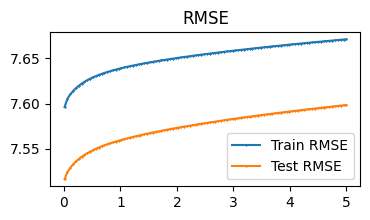

In [409]:
def plot_df(df, column, ax, title="", x_label="", y_label="", legend=""):
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.plot(df.index, df[column], "-*", label=legend, markersize=1)
    ax.legend()
f = plt.figure(figsize=(4,2)); ax = plt.axes()
plot_df(results, "Train RMSE", ax, legend="Train RMSE")
plot_df(results, "Test RMSE", ax, legend="Test RMSE", title="RMSE",)

In [ ]:
f,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(results.index, results.Max_err, "-*"); ax[0].set_title("Max Error in the Model")
ax[1].plot(results.index, results.Pearson, '-*');ax[1].set_title("Pearson Correlation Coef.")

In [ ]:
coefs = pd.DataFrame(columns=X_train.columns)
for alpha in alphas:
    model = Ridge(alpha=alpha).fit(X_train, y_train)
    coefs.loc[alpha] = dict(zip(model.feature_names_in_, model.coef_))
coefs.plot(figsize=(12,10));

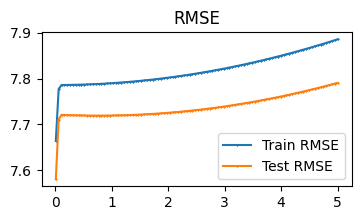

In [411]:
results = pd.DataFrame(columns = ["Pearson", "Test RMSE", "RVE", "Max_err", "Train RMSE"])
for alpha in alphas:
    (train_rmse, test_rmse, 
     pearse, rve, max_err) = get_model_statistics_simple(Lasso(alpha=alpha), X_train, y_train)
    results.loc[alpha] = {"Pearson": pearse,"Test RMSE": test_rmse,"RVE":rve,
        "Max_err": max_err,"Train RMSE": train_rmse}
f = plt.figure(figsize=(4,2)); ax = plt.axes()
plot_df(results, "Train RMSE", ax, legend="Train RMSE")
plot_df(results, "Test RMSE", ax, legend="Test RMSE", title="RMSE",)

In [ ]:
coefs = pd.DataFrame(columns=X_train.columns)
for alpha in alphas:
    model = Ridge(alpha=alpha).fit(X_train, y_train)
    coefs.loc[alpha] = dict(zip(model.feature_names_in_, model.coef_))
coefs.plot(figsize=(12,10));

In [413]:
def plot_stats(x, y, ax, title="", x_label="", y_label="", legend=""):
    ax.set_title(title)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.grid(True)
    ax.plot(x, y, ".",label=legend)
    if legend!="":
        ax.legend()

In [ ]:
def loop(a0, x, y, ax ,xlabel, ylabel="", legend=""):
    for i in range(len(a0)):
        y.append(a0[i][0])
    plot_stats(x, y, ax, x_label=xlabel, y_label=ylabel, legend=legend)

In [418]:
def plot_all_stats(*args, xlabel=""):
    pc =[]
    ttrmse = []
    rve = []
    me = []
    tnrmse = []
    f, ax = plt.subplots(2,2, figsize=(6,4))
    loop(args[0], pc, args[1], a[0,0], "Pearson Corr.")
    loop(args[0], ttrmse, args[1], a[0,1], "RMSE", "Test RMSE")
    loop(args[0], rve, args[1], a[1,0], "RVE")
    loop(args[0], me, args[1], a[1,1], "Max. Error")
    loop(args[0], tnrmse, args[1], a[0,1], "RMSE", "Train RMSE")
    f.tight_layout()
    print(args[0][args[2]])

(0.9155887478922698, 3.293365826218557, 0.8338803558069359, 21.965400000000006, 1.5841904568985608)


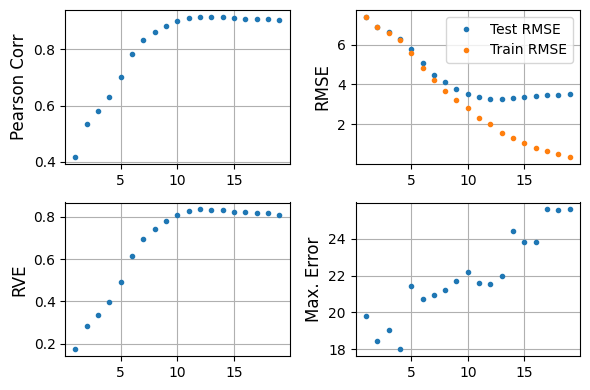

In [419]:
m_depth=[]
n_depth=[]
for d in range(1,20):
    depth=d
    a=get_model_statistics_cv(DecisionTreeRegressor(splitter='best', max_depth=depth, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                              max_features=None, random_state=361, 
                                              max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0), X_train, y_train)
    m_depth.append(a)
    n_depth.append(depth)
plot_all_stats(m_depth, n_depth, 12, "Max. Depth")

In [ ]:
mss=[]
nmss=[]
for s in range(2,50):
    split=s
    a=get_model_statistics_cv(DecisionTreeRegressor(splitter='best', max_depth=13, 
                                              min_samples_split=s, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                              max_features=None, random_state=361, max_leaf_nodes=None, 
                                            min_impurity_decrease=0.0, ccp_alpha=0.0), X_train, y_train)
    mss.append(a)
    nmss.append(split)
plot_all_stats(mss, nmss, 32, "Min. Samples Split")

In [ ]:
msl=[]
nmsl=[]
for l in range(1,10):
    leaf=l
    a=get_model_statistics_cv(DecisionTreeRegressor(splitter='best', max_depth=13, 
                                              min_samples_split=34, min_samples_leaf=l, min_weight_fraction_leaf=0.0, 
                                              max_features=None, random_state=361, max_leaf_nodes=None, 
                                            min_impurity_decrease=0.0, ccp_alpha=0.0), X_train, y_train)
    msl.append(a)
    nmsl.append(leaf)
plot_all_stats(msl, nmsl, 1, "Min. Samples Leaf")

In [ ]:
mf=[]
nmf=[1,2,3]
model = DecisionTreeRegressor(splitter='best', max_depth=13, min_samples_split=34, min_samples_leaf=2, 
                              min_weight_fraction_leaf=0.0, max_features=None, random_state=361, 
                                max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
a=get_model_statistics_cv(model, X_train, y_train)
b=get_model_statistics_cv(model, X_train, y_train)
c=get_model_statistics_cv(model, X_train, y_train)
mf.append(a); mf.append(b); mf.append(c)
plot_all_stats(mf, nmf, 0, "Max. Features")

In [ ]:
mln=[]
nmln=[]
z=get_model_statistics_cv(DecisionTreeRegressor(splitter='best', max_depth=13, 
                                              min_samples_split=34, min_samples_leaf=34, min_weight_fraction_leaf=0.0, 
                                              max_features=None, random_state=361, 
                                              max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0), X_train, y_train)
mln.append(z); nmln.append(0)
for l in range(2,50):
    leaf=l
    a=get_model_statistics_cv(DecisionTreeRegressor(splitter='best', max_depth=13, 
                                              min_samples_split=34, min_samples_leaf=34, min_weight_fraction_leaf=0.0, 
                                              max_features=None, random_state=361, 
                                              max_leaf_nodes=l, min_impurity_decrease=0.0, ccp_alpha=0.0), X_train, y_train)
    mln.append(a); nmln.append(leaf)
plot_all_stats(mln, nmln, 0, "Max. Leaf Nodes")

In [ ]:
mid=[]
nmid=[]
dez=[]
for i in range(31):
    dez.append(i/600)
for i in dez:
    impurity=i
    a=get_model_statistics_cv(DecisionTreeRegressor(splitter='best', max_depth=13, 
                                              min_samples_split=34, min_samples_leaf=2, min_weight_fraction_leaf=0.0, 
                                              max_features=None, random_state=361, 
                                              max_leaf_nodes=None, min_impurity_decrease=i, ccp_alpha=0.0), X_train, y_train)
    mid.append(a)
    nmid.append(impurity)
plot_all_stats(mid, nmid, 15, "Min. Impurity Decrease")

In [338]:
get_model_statistics_cv(DecisionTreeRegressor(splitter='best', max_depth=13, 
                                              min_samples_split=34, min_samples_leaf=2, 
                                              min_weight_fraction_leaf=0.0, 
                                              max_features=None, random_state=361, 
                                              max_leaf_nodes=None, min_impurity_decrease=0.025, 
                                              ccp_alpha=0.0), X_train, y_train)

(0.9308201935003684,
 2.966368667047948,
 0.8659370527232023,
 21.005658536585358,
 2.571550254121365)

## Validação

In [339]:
X_IND=X_IND.drop(columns=['subject#','test_time'])

In [340]:
modelo=DecisionTreeRegressor(splitter='best', max_depth=13, min_samples_split=34, 
                             min_samples_leaf=2, min_weight_fraction_leaf=0.0, 
                            max_features=None, random_state=361, max_leaf_nodes=None, 
                             min_impurity_decrease=0.025, ccp_alpha=0.0).fit(X_train,y_train)
preds=modelo.predict(X_IND)

In [341]:
print("Pearson:", np.corrcoef(y_IND, preds)[0,1])
print("Test RMSE:", np.sqrt( mean_squared_error( y_IND, preds) ))
print("Max err:", max_error(y_IND, preds ))
print("RVE: ", explained_variance_score(y_IND, preds))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, modelo.predict(X_train))))

Pearson: 0.933838062240891
Test RMSE: 2.906698676507129
Max err: 14.219776041666652
RVE:  0.8714433159104555
Train RMSE: 2.538464349864012


# Objetivo 2

In [386]:
data = pd.read_csv("parkinsons_updrs.data")

In [387]:
#Separate X from y
X = data.drop(columns=["total_UPDRS", "motor_UPDRS"])
y = data["total_UPDRS"].map(lambda x: 1 if x>40 else 0)

In [389]:
#Separate Training set from Independent Validations Set
(X_train, X_IND, 
 y_train, y_IND) = train_test_split(X, y, test_size=361, random_state=361)

In [390]:
#join X and y from the training set
data_train = pd.concat((X_train, y_train), axis=1 )
X_train = X_train.drop(columns=["subject#", "test_time"])

In [391]:
def get_model_statistics_simple(model, X, y, plot=False, *args, **kwargs):    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    #fit model
    temp_model = model.fit(X_train, y_train)
    #get predictions on test set
    X_test = scaler.transform(X_test)
    preds = temp_model.predict(X_test)
    #get statistics
    if np.any(preds)==1:
        prec = precision_score(y_test, preds)
    else:
        prec = np.nan
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    mcc = matthews_corrcoef(y_test, preds)
    #return statistics estimations
    return (prec,recall,f1,mcc)

In [392]:
def get_model_statistics_cv(model, X, y):
    kf = KFold(n_splits=16)
    #statistic arrays
    prec = []
    recall = []
    f1 = []
    mcc = [] 
    #Get the train/test folds
    for train_index, test_index in kf.split(X):
        #Create train/test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        #fit model
        temp_model = model.fit(X_train, y_train)
        #get predictions on test set
        X_test = scaler.transform(X_test)
        preds = temp_model.predict(X_test)
        #get statistics
        if np.any(preds)==1:
            prec.append(precision_score(y_test, preds))
        recall.append( recall_score(y_test, preds) )
        f1.append( f1_score(y_test, preds) )
        mcc.append( matthews_corrcoef(y_test, preds) )
    #return statistics estimations
    return (np.mean(prec),np.mean(recall),np.mean(f1),np.mean(mcc))

In [393]:
def plot_df(df, column, ax, title="", x_label="", y_label="", legend=""):
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    
    ax.plot(df.index, df[column], "-*", label=legend)
    ax.grid(True)
    if legend!="":
        ax.legend()

In [394]:
def plot_all_stats(stats, xlabel=""):
    f, ax = plt.subplots(2,2)
    plot_df(stats, "Precision", ax[0,0], x_label = xlabel, y_label="Precision Score")
    plot_df(stats, "Recall", ax[0,1], x_label = xlabel, y_label="Recall Score")
    plot_df(stats, "F1 Score", ax[1,0], x_label = xlabel, y_label="F1 Score")
    plot_df(stats, "MCC", ax[1,1], x_label = xlabel, y_label="MCC")
    f.tight_layout()
    print(stats.idxmax())

In [395]:
criteria = ["gini", "entropy"]; max_depth = range(3, 30+1) ;min_sample_split = range(2, 30+1)
min_samples_leaf = range(1, 50+1); max_leaf_nodes = range(2,50); min_imp = np.linspace(0,0.05,100)
columns = ["Precision", "Recall", "F1 Score", "MCC"]

In [ ]:
# max_depth
stats = pd.DataFrame(columns=columns)
for d in max_depth:
    temp = get_model_statistics_cv(
        DecisionTreeClassifier(criterion=criteria[1], max_depth=d), X_train, y_train,)
    stats.loc[d] = dict(zip(columns, temp))
plot_all_stats(stats, xlabel="Max. Depth")

In [ ]:
# min_sample_split
stats = pd.DataFrame(columns=columns)
for s in min_sample_split:
    temp = get_model_statistics_cv(
        DecisionTreeClassifier(criterion=criteria[1], max_depth=7, 
                               min_samples_split=s), X_train, y_train,)
    stats.loc[s] = dict(zip(columns, temp))
plot_all_stats(stats, xlabel="Min. Samples Split")

In [ ]:
#min_samples_leaf
stats = pd.DataFrame(columns=columns)
for s in min_samples_leaf:
    temp = get_model_statistics_cv(
        DecisionTreeClassifier(criterion=criteria[1], max_depth=7,
                               min_samples_split=29, min_samples_leaf=s), X_train, y_train,)
    stats.loc[s] = dict(zip(columns, temp))
plot_all_stats(stats, xlabel="Min. Samples Leaf")

In [ ]:
#max_leaf_nodes
stats = pd.DataFrame(columns=columns)
for s in max_leaf_nodes:
    temp = get_model_statistics_cv(
        DecisionTreeClassifier(criterion=criteria[1], max_depth=7,
                               min_samples_split=29, min_samples_leaf=4,
                              max_leaf_nodes=s), X_train, y_train,)
    stats.loc[s] = dict(zip(columns, temp))
plot_all_stats(stats, xlabel="Max. Leaf Nodes")

In [ ]:
#min_impurity_decrease
stats = pd.DataFrame(columns=columns)
for s in min_imp:
    temp = get_model_statistics_cv(
        DecisionTreeClassifier(criterion=criteria[1], max_depth=7, min_samples_split=29, 
                                min_samples_leaf=4, max_leaf_nodes=28, 
                               min_impurity_decrease=s), X_train, y_train,)
    stats.loc[s] = dict(zip(columns, temp))
plot_all_stats(stats, xlabel="Min. Impurity Decrease")

In [354]:
dt = DecisionTreeClassifier(criterion=criteria[1], max_depth=7,
                               min_samples_split=29, min_samples_leaf=4,
                              max_leaf_nodes=28)
get_model_statistics_cv(dt, X_train, y_train)

(0.8215224587034152,
 0.8022553855948714,
 0.8107803065844441,
 0.7731348771480981)

In [ ]:
for col in X_train.columns:
    data_train.plot(x=col, y="total_UPDRS", ls="", marker="*", markersize=1, ylabel="total_UPDRS > 40")

In [356]:
(pred, recall,
 f1, mcc) = get_model_statistics_cv(LogisticRegression(random_state=361), X_train, y_train, normalize = True)
print("Precision:", pred, "\nRecall:", recall, "\nF1:", f1, "\nMCC", mcc)

Precision: 0.3181818181818182 
Recall: 0.004364296556358917 
F1: 0.008547730854026252 
MCC 0.014537910213583069


## Validação

In [357]:
dt = DecisionTreeClassifier(criterion=criteria[1], max_depth=7, min_samples_split=29, 
                            min_samples_leaf=4, max_leaf_nodes=28)
scaler = StandardScaler().fit(X_train)
dt.fit(scaler.transform(X_train), y_train)
preds = dt.predict(scaler.transform(X_IND.drop(columns=["subject#", "test_time"])))
print(precision_score(y_IND, preds), recall_score(y_IND, preds), f1_score(y_IND, preds),
    matthews_corrcoef(y_IND, preds), sep="\n")

0.8275862068965517
0.7868852459016393
0.8067226890756303
0.7689594000412863
